In [1]:
!pip install ipywidgets

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
import numpy as np
import obspy
from hydrophone_data_processing import load, useful_variables, plotting, signal_processing
import scipy.signal as signal
import pandas as pd
import matplotlib.dates as dates
import obspy.signal.trigger as trigger
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import config
from event_pipeline import Event
from obspy.imaging.spectrogram import spectrogram
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import Pool

def import_data(day, starttime, endtime):
    daypaths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day)
    starttime = obspy.UTCDateTime(starttime)
    endtime = obspy.UTCDateTime(endtime)
    data = load.import_corrected_data_for_single_day(daypaths)
    data.trim(starttime=starttime, endtime=endtime)
    return data

In [4]:
day141 = import_data(day=141, starttime='2019-05-21T07:00:00.0Z', endtime='2019-05-21T09:00:00.0Z')
day188 = import_data(day=188, starttime='2019-07-07T08:40:00.0Z', endtime='2019-07-07T10:15:00.0Z')
day197 = import_data(day=197, starttime='2019-07-16T21:45:00.0Z', endtime='2019-07-17T00:00:00.337999Z')
day211 = import_data(day=211, starttime='2019-07-30T22:30:05.142999Z', endtime='2019-07-30T23:07:04.430999Z')

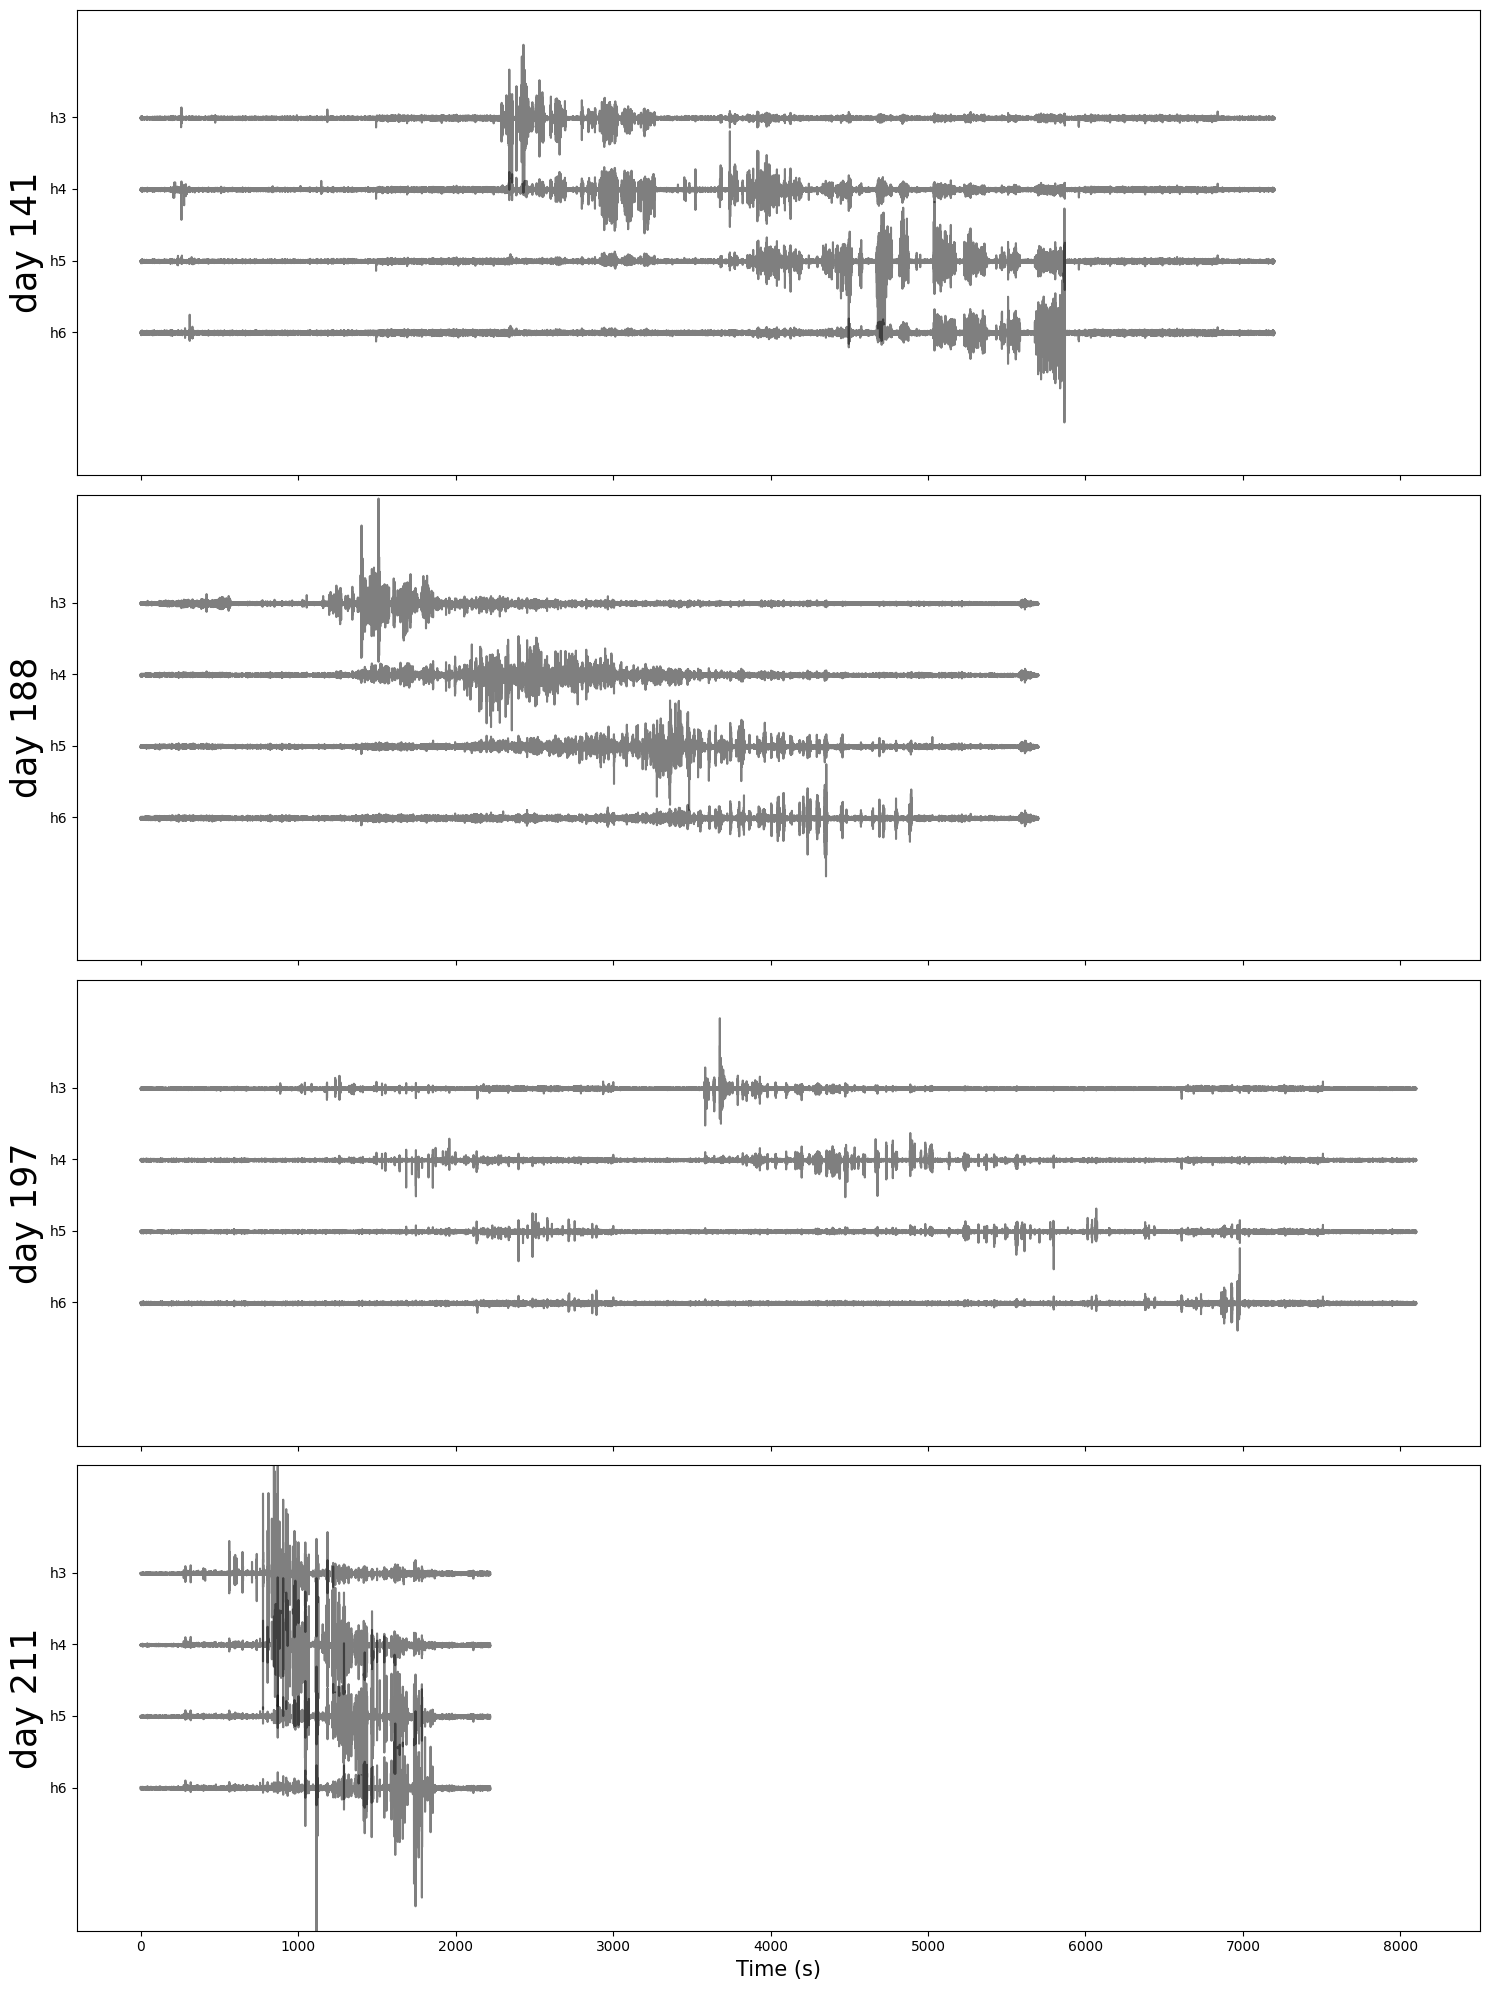

In [5]:
fig, ax = plt.subplots(4, 1, figsize=(15, 20), sharey=True, sharex=True)

def plot_waveform(ax, stream, day):
    times = np.array([tr.times() for tr in stream][2:])
    data = [tr.data for tr in stream][2:]
    n = 0
    for t, d in zip(times, data):
        ax.plot(t, d - n * 10, color='black', alpha=0.5)
        n+=1
        
    ax.set_ylabel('day ' + str(day), fontsize=25)

plot_waveform(ax=ax[0], stream=day141, day=141)
plot_waveform(ax=ax[1], stream=day188, day=188)
plot_waveform(ax=ax[2], stream=day197, day=197)
plot_waveform(ax=ax[3], stream=day211, day=211)

ax[0].set_ylim(-50, 15)
ax[0].set_yticks([0, -10, -20, -30])
ax[0].set_yticklabels(['h3', 'h4', 'h5', 'h6'])

ax[3].set_xlabel('Time (s)', fontsize=15)

plt.tight_layout()

fig.savefig('paperfigs/raw_waveforms.pdf', bbox_inches='tight')

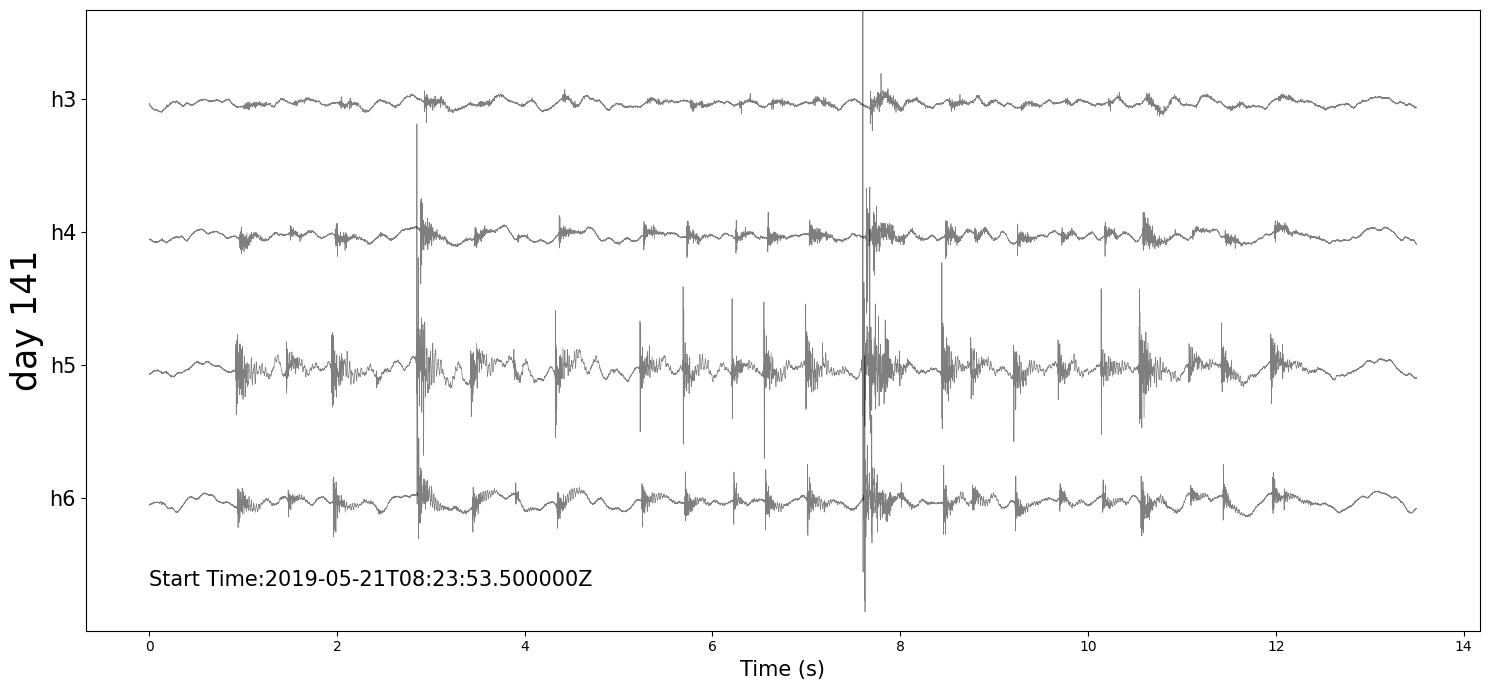

In [6]:
def plot_waveform(ax, stream, day):
    times = np.array([tr.times() for tr in stream][2:])
    data = [tr.data for tr in stream][2:]
    n = 0
    for t, d in zip(times, data):
        ax.plot(t, d - n * 3, color='black', linewidth=0.5, alpha=0.5)
        n+=1
        
    ax.set_ylabel('day ' + str(day), fontsize=25)

fig, ax = plt.subplots(figsize=(15, 7))
starttime = obspy.UTCDateTime('2019-05-21T08:23:53.500000Z')
endtime = obspy.UTCDateTime('2019-05-21T08:24:07.000000Z')
plot_waveform(ax=ax, stream=day141.copy().trim(starttime, endtime), day=141)
ax.set_ylim(-12, 2)
ax.set_yticks(np.array([0, -1, -2, -3])*3)
ax.set_yticklabels(['h3', 'h4', 'h5', 'h6'], fontsize=15)
ax.set_xlabel('Time (s)', fontsize=15)
ax.text(s=f'Start Time:{starttime}', x=0, y=-11, fontsize=15)
fig.tight_layout()
fig.savefig('paperfigs/zoom_swarm.pdf', bbox_inches='tight')

In [7]:

def import_catalog(file):
    df = pd.read_csv(file)
    df.sort_values(by='first_arrival', inplace=True)
    df['arrival_datetime'] = df.arrival_time.apply(dates.num2date)
    return df

def plot_depths(df, cmap, day):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.scatter(df.arrival_datetime, df.depth, marker='.', linewidth=0, c=df.first_hydrophone, cmap=cmap)
    ax.set_ylabel('day '+str(day), fontsize=25)
    ax.set_ylim(400, 50)
    return fig, ax

In [8]:
df141 = import_catalog(file='141precision.csv')
df188 = import_catalog(file='188precision.csv')
df197 = import_catalog(file='197precision.csv')
df211 = import_catalog(file='211precision.csv')


In [9]:
# also need to remove a number of columns that are simply irrelevant to the analysis or untested for a shareable dataset.

columns_to_keep = ['id', 'depth', 'relative_depth',
        'first_hydrophone', 'second_hydrophone',
       'arrival_time', 'first_arrival', 'second_arrival', 'dt',
       'max_amp', 'cum_amp', 'arrival_datetime', 'origin_time']

df141 = df141[columns_to_keep].copy()
df188 = df188[columns_to_keep].copy()
df197 = df197[columns_to_keep].copy()
df211 = df211[columns_to_keep].copy()

df141.sort_values(by='arrival_datetime', inplace=True)
# df188.sort_values(by='arrival_datetime', inplace=True)
# df197.sort_values(by='arrival_datetime', inplace=True)
# df211.sort_values(by='arrival_datetime', inplace=True)

# # removing the events with maximum amplitude <0.1 since they are false positives
df141 = df141[df141.max_amp > 0.1].copy()
df188 = df188[df188.max_amp > 0.1].copy()
df197 = df197[df197.max_amp > 0.1].copy()
df211 = df211[df211.max_amp > 0.1].copy()

df141.drop_duplicates(subset=['arrival_datetime',], inplace=True)
df188.drop_duplicates(subset=['arrival_datetime',], inplace=True)
df197.drop_duplicates(subset=['arrival_datetime',], inplace=True)
df211.drop_duplicates(subset=['arrival_datetime',], inplace=True)

In [10]:
print('length of day 141 swarm in seconds:', pd.Timedelta(np.array(df141.arrival_datetime.tail(1).values - df141['arrival_datetime'].head(1).values)[0]).total_seconds())

length of day 141 swarm in seconds: 3545.596


In [11]:
print('day141 N-events:', df141.shape)
# print('day188 N-events:', df188.shape)
# print('day197 N-events:', df197.shape)
# print('day211 N-events:', df211.shape)

day141 N-events: (1931, 13)


In [12]:
def get_swarm_time_length(df):
    start = df.head(1).arrival_datetime.values
    end = df.tail(1).arrival_datetime.values
    tl = (end - start)/np.timedelta64(1, 's')
    return tl[0]
print('Day 141 event length:', get_swarm_time_length(df141))
# print('Day 188 event length:', get_swarm_time_length(df188))
# print('Day 197 event length:', get_swarm_time_length(df197))
# print('Day 211 event length:', get_swarm_time_length(df211))

Day 141 event length: 3545.596


In [13]:
from event_pipeline import Event
import torchaudio.transforms as T
import librosa
import torch

import matplotlib.dates as mdates
import datetime


def get_event(event_id, day_number, df, hanning=True):
    paths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day_number)
    waveforms = load.import_corrected_data_for_single_day(paths=paths)
    df = df.copy()
    e = Event(id=event_id
              , starttime=df.arrival_time.loc[event_id]
              , init_first_hphone=df.first_hydrophone
              , waveforms=waveforms
              , hanning=hanning
             )
    return e

def get_times(event):
    trace = event.stream[event.first_hydrophone_id]
    times = trace.times()
    times_len = times.shape[0]
    return np.arange(0, times_len, 1)

def plot_spectrogram(event, ax):
    trace = event.stream[event.first_hydrophone_id]
    torch_data = torch.from_numpy(trace.data)
    spectrogram = T.Spectrogram(n_fft=2**6, hop_length=1)
    spec = spectrogram(torch_data)
    ax.imshow(librosa.power_to_db(spec), origin='lower', aspect='auto', cmap='gist_rainbow')
    

def plot_50hz_highpass(event, ax):
    trace = event.stream[event.first_hydrophone_id].copy()
    times = get_times(event=event)
    tr = trace.filter(type='highpass', freq=50)
    ax.plot(times, tr.data, color='violet', label='50Hz highpass'
            ,linewidth=2)

def plot_aic_pick(event, ax):
    times = get_times(event=event)
    # its 0.4 because its 2/5 because its 0.2s before and 0.3 after
    aic_time = times[int(0.4*times.shape[0])]
    ax.vlines(x=aic_time, ymin=-0.5, ymax=0.7, color='cyan'
              ,linewidth=3, label='AIC pick')

def plot_p(event, ax):
    trace = event.stream[event.first_hydrophone_id]
    times = get_times(event=event)
    tr = trace.filter(type='highpass', freq=50)
    
    # find max/min peak
    start = 180
    end = 199
    if np.max(tr.data[start:end]) > np.min(tr.data[start:end]):
        ploc_t = times[np.argmax(tr.data[start:end]) + start]
        ploc_y = np.max(tr.data[start:end])
    else:
        ploc_t = times[np.argmin(tr.data[start:end]) + start]
        ploc_y = np.min(tr.data[start:end])
    
    # ax.plot(times, tr.data, color='cyan', alpha=0.5, label='what is this?')
    print(ploc_t, ploc_y)
    print(tr.data.shape)
    ax.plot(ploc_t, ploc_y, marker='*', linestyle='', color='red', label='p-arrival pick')

def plot_aic(event, ax):
    times = get_times(event=event)
    AICs = event.aics[event.first_hydrophone_id]
    ax.plot(times, AICs, color='cyan', linewidth=2.5)

def plot_aic_diff(event, ax):
    times = get_times(event=event)
    AICs = event.aics[event.first_hydrophone_id]
    aic_diffs = np.diff(AICs)
    ax.plot(times[1:], aic_diffs, color='magenta')

def plot_event(event_id, day_number, df):
    
    e = get_event(event_id=event_id, day_number=day_number, df=df)
    
    fig, ax = plt.subplots(3, 1, figsize=(15, 8), sharex=True)

    plot_50hz_highpass(event=e, ax=ax[0])
    
    plot_aic_pick(event=e,  ax=ax[0])

    # plot_p(event=e, ax=ax[0])
    # ax[0].arrow(x=0.195*1e3, y=0.75, dx=0, dy=-0.6, color='red', head_width=1, head_length=0.05
    #            ,label=r'$p$-arrival')    
    ax[0].scatter((0.195*1e3,), (0.15,), marker=r'$\downarrow$', s=200, color='red', label=r'$p$-arrival')
    plot_aic(event=e, ax=ax[1])
    
    ax2 = ax[1].twinx()
    
    plot_aic_diff(event=e, ax=ax2)
    
    plot_spectrogram(event=e, ax=ax[2])
    
    ax[0].set_ylabel('Pressure (Pa)', fontsize=15)
    ax[0].legend(fontsize=15, loc='lower right')
    ax[1].set_ylabel('AIC', fontsize=15, color='magenta')
    ax2.set_ylabel('diff(AIC)', fontsize=15, color='cyan')
    ax[2].set_ylabel('Hz', fontsize=15)
    ax[2].set_yticks(np.arange(0, 32, 5))
    ax[2].set_yticklabels(np.arange(0, 32, 5) * 500 / 32)
    fig.tight_layout()
    return fig, ax

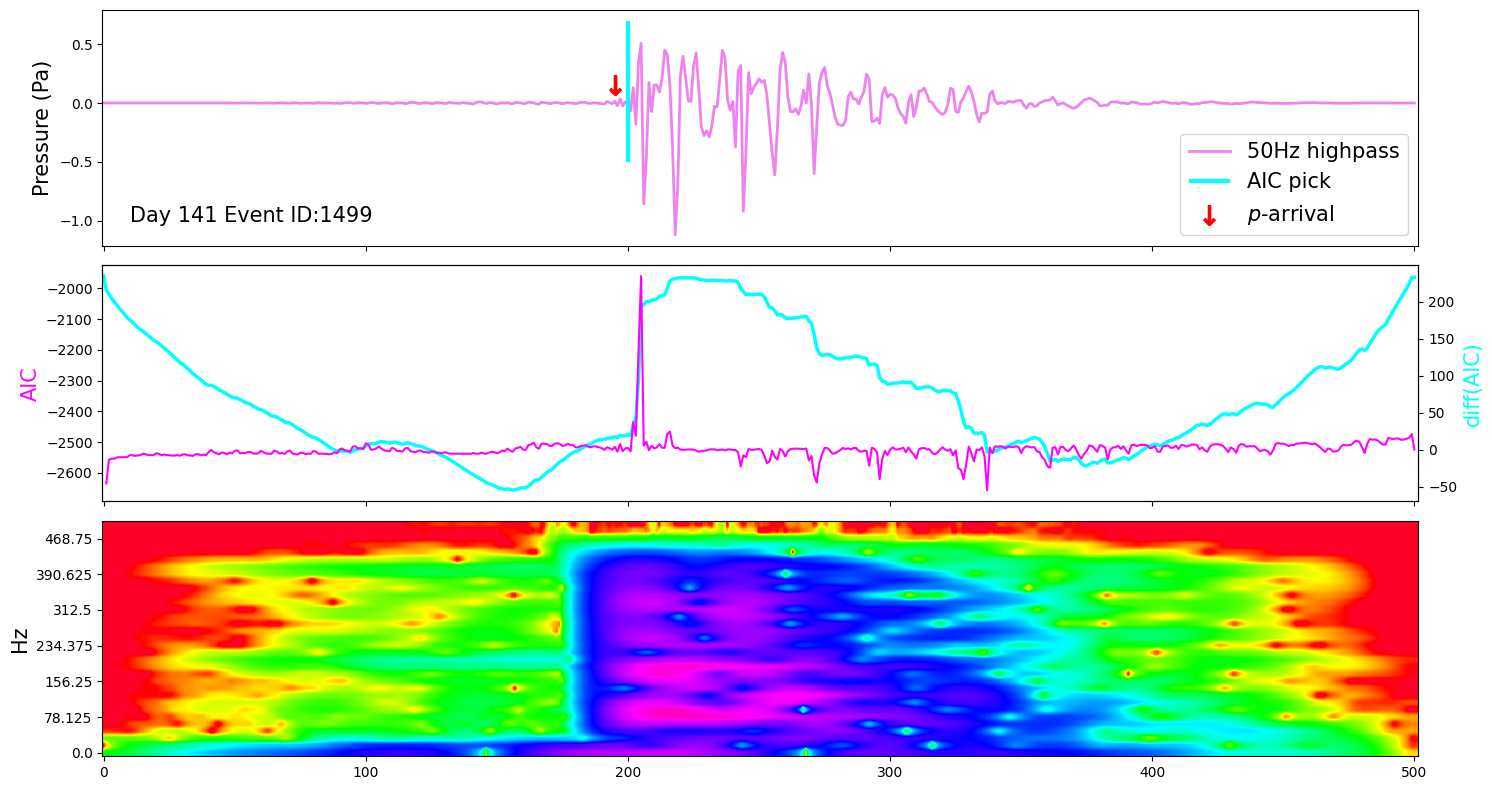

In [14]:
fig, ax = plot_event(event_id=1499, day_number=141, df=df141)
ax[0].text(s='Day 141 Event ID:1499', fontsize=15, x=10, y=-1.01)
fig.savefig('paperfigs/example_detections.pdf', bbox_inches='tight')

$$ v = \frac{d_{relative}}{t_{origin} - t_{p}}$$

amplitude: 273.18656548251727
3545.5959999999936
amplitude: 56.95750129387181
4591.384000000003
amplitude: 71.58338982931284
6621.809998999994
amplitude: 557.2534597217959
1581.1760000000008


/tmp/ipykernel_52229/132378703.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, s=s*10, alpha=0.3, c=plt.cm.twilight(0.4))
/tmp/ipykernel_52229/132378703.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, s=s*10, alpha=0.3, c=plt.cm.twilight(0.4))
/tmp/ipykernel_52229/132378703.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as

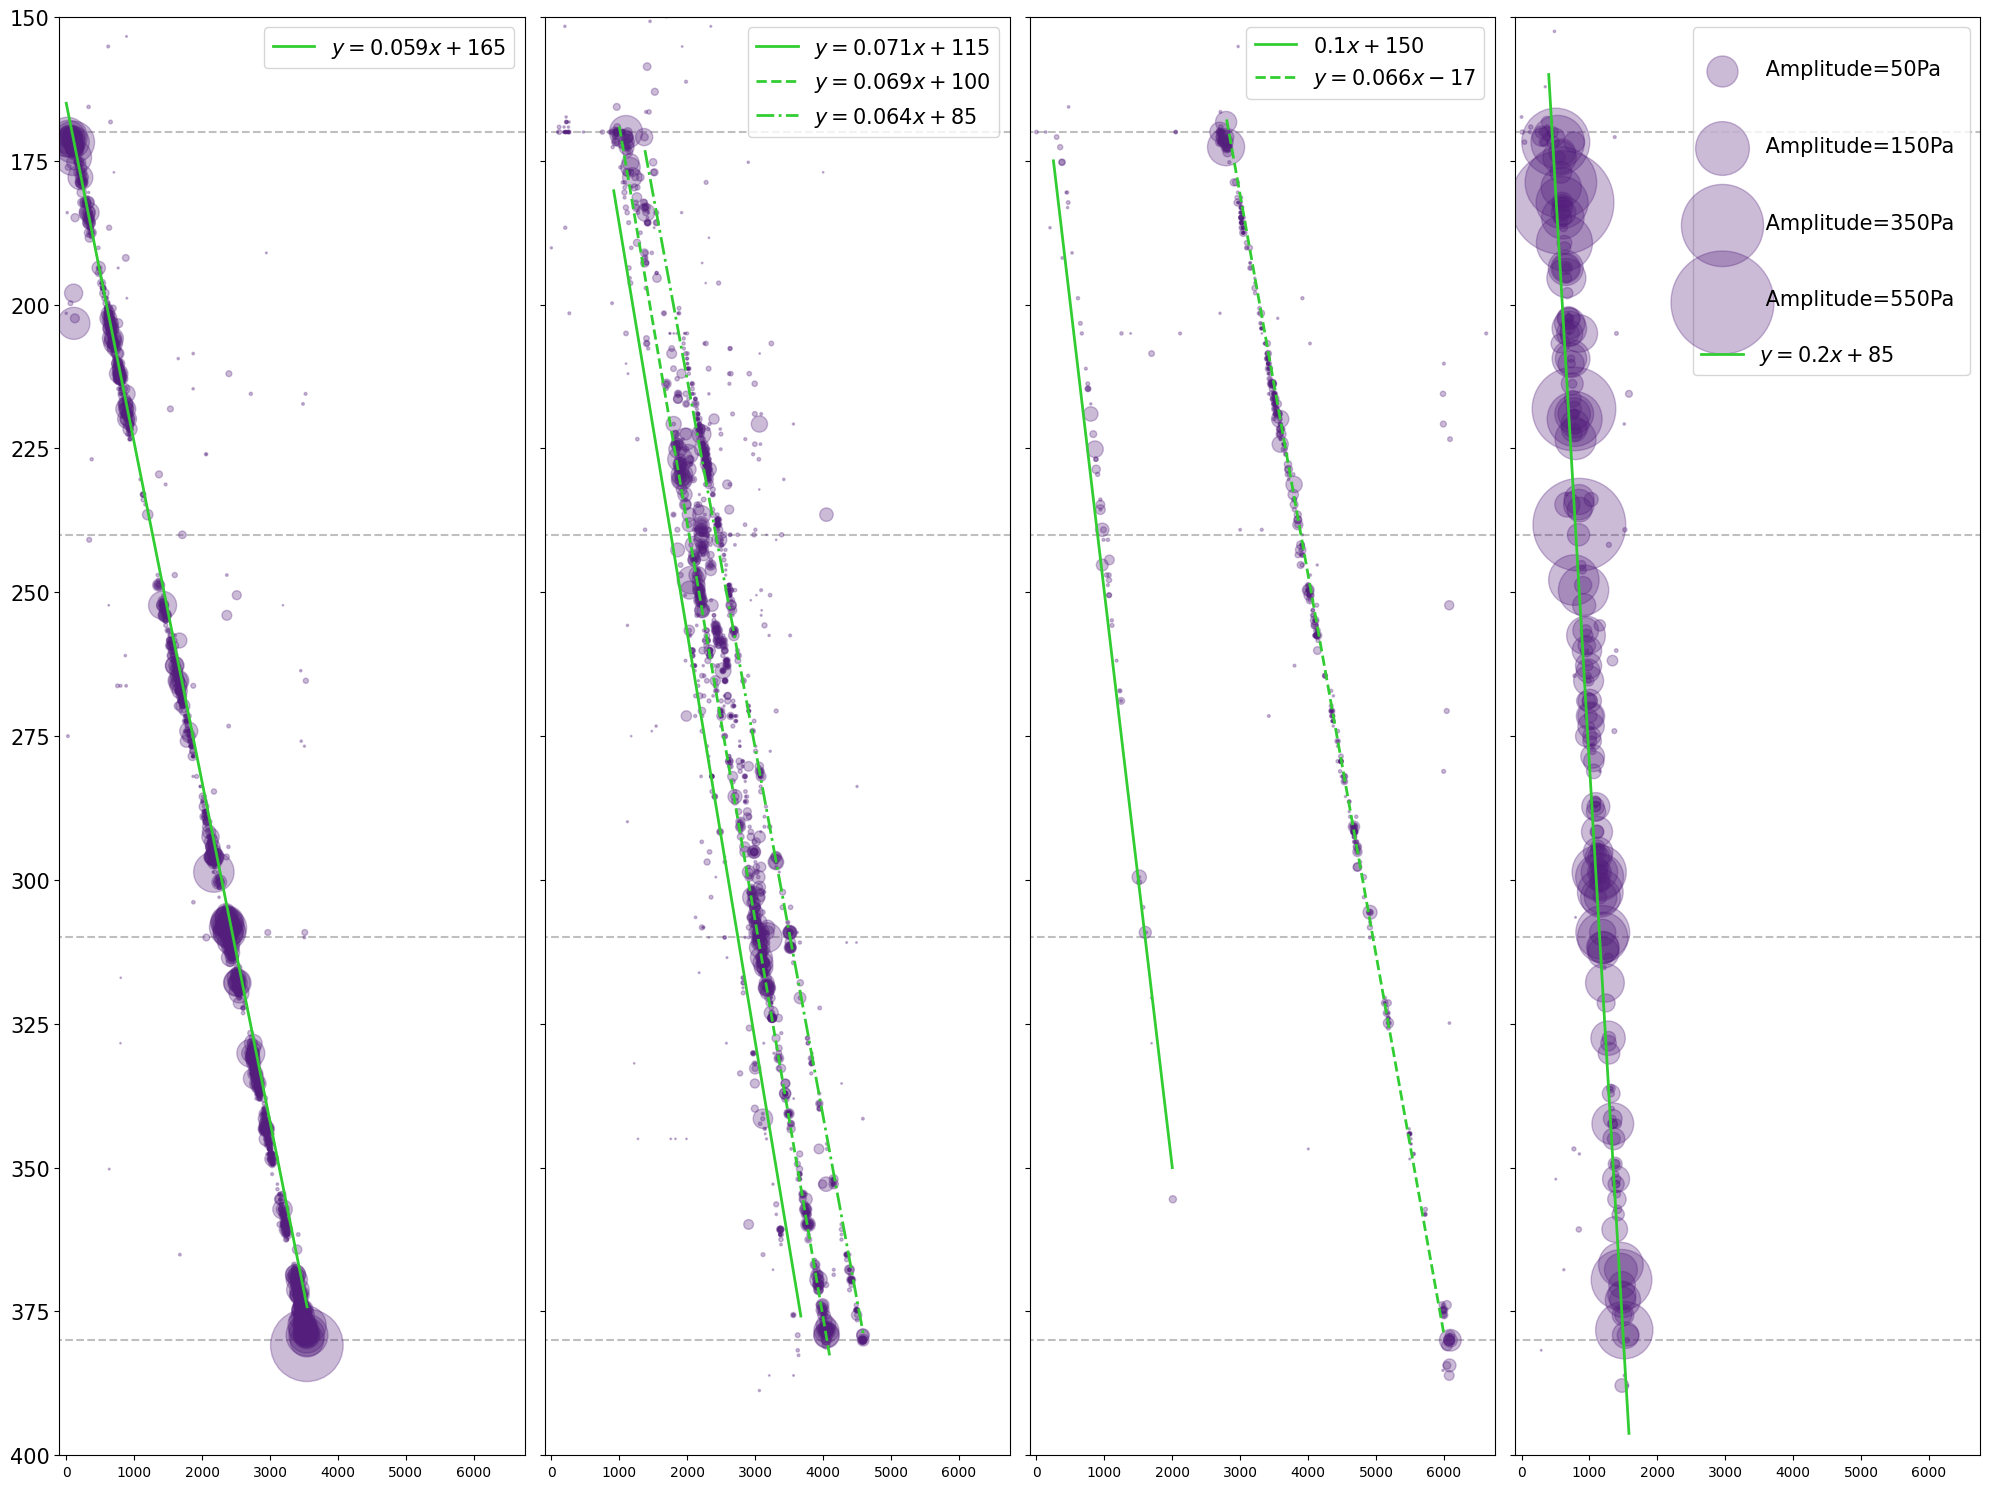

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(20, 15), sharey=True, sharex=True)

ax[3].scatter([0], [0], s=[50*10,], alpha=0.3, color=plt.cm.twilight(0.4), label='\n Amplitude=50Pa \n')
ax[3].scatter([0], [0], s=[150*10,], alpha=0.3, color=plt.cm.twilight(0.4), label='\n Amplitude=150Pa \n')
ax[3].scatter([0], [0], s=[350*10,], alpha=0.3, color=plt.cm.twilight(0.4), label='\n Amplitude=350Pa \n')
ax[3].scatter([0], [0], s=[550*10,], alpha=0.3, color=plt.cm.twilight(0.4), label='\n Amplitude=550Pa \n')
ax[3].legend(fontsize=15, edgecolor='None')

def plot_events(data, ax):
    x = data['arrival_datetime'].diff().apply(lambda t: t.total_seconds()).fillna(0).cumsum().values
    y = data['depth'].values
    s = data['max_amp'].values
    print('amplitude:',s.max())
    print(x.max())
    # ax.scatter(x/x.max(), y, s=s*10, alpha=0.3, c=plt.cm.twilight(0.4))
    ax.scatter(x, y, s=s*10, alpha=0.3, c=plt.cm.twilight(0.4))
    return x.max()

def plot_best_fit_line(slope, intercept, ax, xstart=0, xend=1, **kwargs):
    x = np.linspace(xstart, xend, 1000)
    y = slope * x + intercept
    ax.plot(x, y, color='limegreen', linewidth=2, **kwargs)

def plot_hydrophone_depth_horizontal_line(hid, ax):
    hids = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']
    for hid in hids:
        depth = config.hydrophone_metadata_141[hid]['depth']
        ax.hlines(y=depth, xmin=-70000, xmax=700000, linestyle='--', color='black', alpha=0.25, zorder=0)

plot_hydrophone_depth_horizontal_line(hid='h3', ax=ax[0])
plot_hydrophone_depth_horizontal_line(hid='h4', ax=ax[1])
plot_hydrophone_depth_horizontal_line(hid='h5', ax=ax[2])
plot_hydrophone_depth_horizontal_line(hid='h6', ax=ax[3])
    
x141 = plot_events(data=df141, ax=ax[0])
x188 = plot_events(data=df188, ax=ax[1])
x197 = plot_events(data=df197, ax=ax[2])
x211 = plot_events(data=df211, ax=ax[3])

plot_best_fit_line(slope=0.059, intercept=165
                   , ax=ax[0], xstart=0, xend=x141
                  , label=r'$y = 0.059 x + 165$')

plot_best_fit_line(slope=0.071, intercept=115
                   , ax=ax[1], xstart=0.2*x188, xend=0.8*x188
                  , label=r'$y = 0.071 x + 115$')

plot_best_fit_line(slope=0.069, intercept=100
                   , ax=ax[1], xstart=1000, xend=4100
                  ,linestyle='--', label=r'$y = 0.069x + 100$')

plot_best_fit_line(slope=0.064, intercept=85
                   , ax=ax[1], xstart=0.3*x188, xend=1*x188
                  ,linestyle='-.', label=r'$y = 0.064x + 85$')

plot_best_fit_line(slope=0.1, intercept=150
                   , ax=ax[2], xstart=250, xend=2000
                  ,label=r'$0.1 x + 150$')

plot_best_fit_line(slope=0.066, intercept=-17
                   , ax=ax[2], xstart=2800, xend=6000
                  ,linestyle='--', label=r'$y = 0.066 x - 17$')

plot_best_fit_line(slope=0.2, intercept=80
                   , ax=ax[3], xstart=400, xend=1581
                  ,label=r'$y = 0.2 x + 85$')

ax[0].set_yticks(np.arange(150, 425, 25))
ax[0].set_yticklabels(np.arange(150, 425, 25), fontsize=15)
ax[0].set_ylim(400, 150)
ax[0].set_xlim(-100, 6750)
fig.tight_layout()
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)
ax[2].legend(fontsize=15)
ax[3].legend(fontsize=15)

fig.savefig('paperfigs/events.pdf')

/tmp/ipykernel_52229/134083137.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  cbar = ax.scatter(data['dt'], data.ones, c=c, s=df['max_amp']*9, label=label, marker='.', alpha=0.5)
/tmp/ipykernel_52229/134083137.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  cbar = ax.scatter(data['dt'], data.ones, c=c, s=df['max_amp']*9, label=label, marker='.', alpha=0.5)
/tmp/ipykernel_52229/134083137.py:11: UserWarning: *c* arg

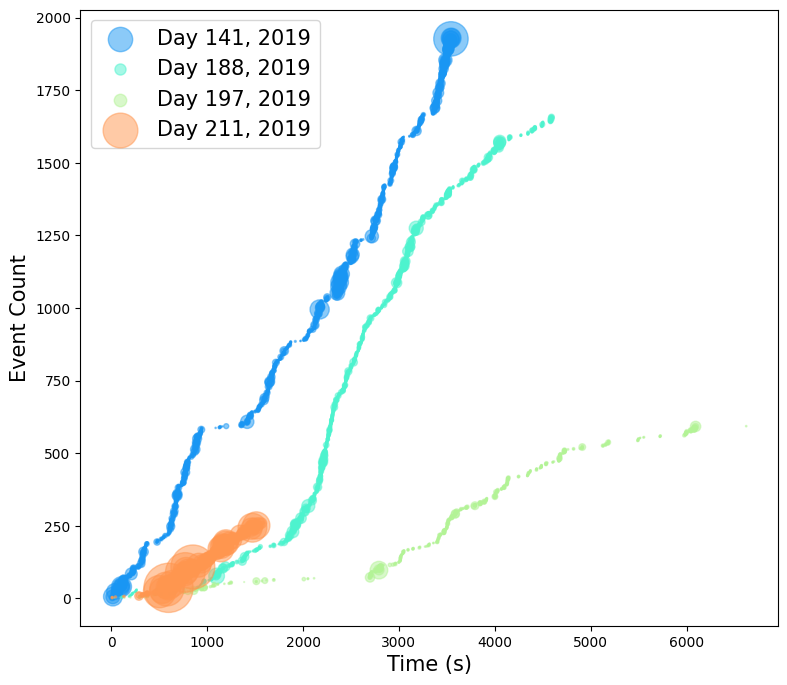

In [16]:
fig, ax = plt.subplots(figsize=(9, 8))

def make_cumcurve_with_depth(df, label, c=plt.cm.YlGnBu(0.2)):
    data = df[['arrival_datetime', 'depth']].copy()
    data.sort_values(by='arrival_datetime', inplace=True)
    data['dt'] = data['arrival_datetime'].diff().apply(lambda t: t.total_seconds()).cumsum()
    data['ones'] = 1
    data['ones'] = data['ones'].cumsum()
    # data['ones'] = data['ones']/data['ones'].max()
    # cbar = ax.scatter(data['dt']/data['dt'].max(), data.ones, c=c, s=df['max_amp']*4, label=label, marker='.', alpha=0.25)
    cbar = ax.scatter(data['dt'], data.ones, c=c, s=df['max_amp']*9, label=label, marker='.', alpha=0.5)
    return cbar


make_cumcurve_with_depth(df141, label='Day 141, 2019',c=plt.cm.rainbow(0.2))
make_cumcurve_with_depth(df188, label='Day 188, 2019',c=plt.cm.rainbow(0.4))
make_cumcurve_with_depth(df197, label='Day 197, 2019',c=plt.cm.rainbow(0.6))
make_cumcurve_with_depth(df211, label='Day 211, 2019',c=plt.cm.rainbow(0.8))
# print(cbar)
# fig.colorbar(cbar)
ax.legend(fontsize=15)
ax.set_xlabel('Time (s)', fontsize=15)
ax.set_ylabel(r'Event Count', fontsize=15)
# ax.set_yscale('log')
# ax.set_ylim(0, 500)
# ax.set_xlim(0, 1000)

fig.savefig('paperfigs/event_cdf_depth.pdf', bbox_inches='tight')

# SUPPLEMENTAL FIGURES

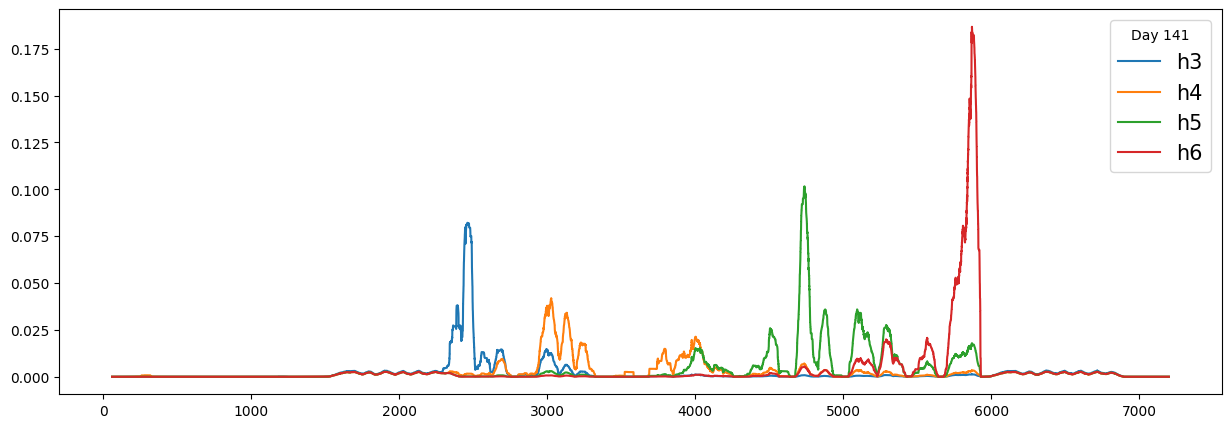

In [17]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    # return (ret[n - 1:] / n)/ret.max()
    return ret[n - 1:] / n

fig, ax = plt.subplots(figsize=(15, 5))

window_size = 1000*60

day141 = import_data(day=141, starttime='2019-05-21T07:00:00.0Z', endtime='2019-05-21T09:00:00.0Z')
day141.filter(type='highpass', freq=50)

ax.plot(day141[2].times()[window_size - 1:], moving_average(day141[2].data**2, n=window_size), label='h3')
ax.plot(day141[3].times()[window_size - 1:], moving_average(day141[3].data**2, n=window_size), label='h4')
ax.plot(day141[4].times()[window_size - 1:], moving_average(day141[4].data**2, n=window_size), label='h5')
ax.plot(day141[5].times()[window_size - 1:], moving_average(day141[5].data**2, n=window_size), label='h6')
ax.legend(fontsize=15, title='Day 141')

# ax[0].plot(h5.times(), moving_average(h5.data**2, n=5000))
# ax[0].plot(h6.times(), moving_average(h6.data**2, n=5000), alpha=0.5)



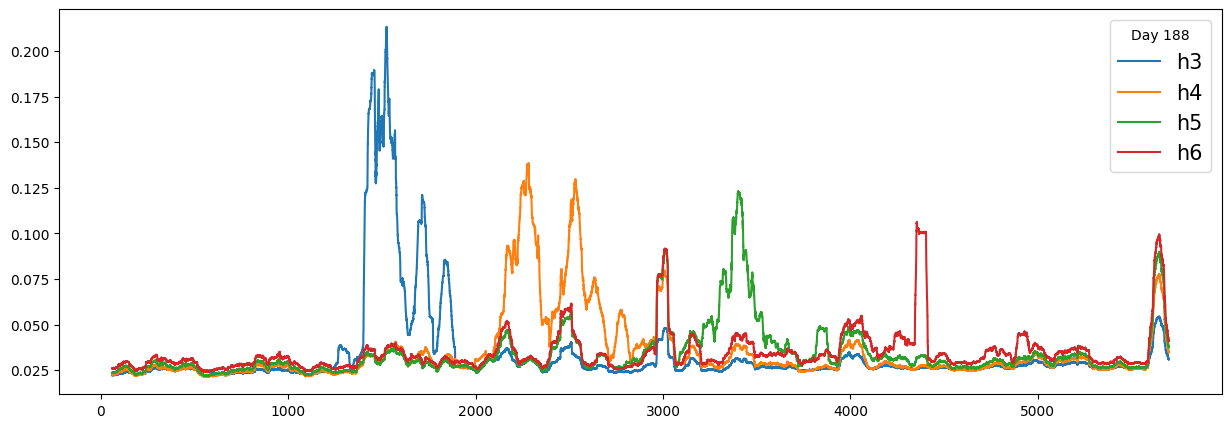

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))

window_size = 1000*60

# day188 = import_data(day=141, starttime='2019-05-21T07:00:00.0Z', endtime='2019-05-21T09:00:00.0Z')
# day141.filter(type='highpass', freq=50)

ax.plot(day188[2].times()[window_size - 1:], moving_average(day188[2].data**2, n=window_size), label='h3')
ax.plot(day188[3].times()[window_size - 1:], moving_average(day188[3].data**2, n=window_size), label='h4')
ax.plot(day188[4].times()[window_size - 1:], moving_average(day188[4].data**2, n=window_size), label='h5')
ax.plot(day188[5].times()[window_size - 1:], moving_average(day188[5].data**2, n=window_size), label='h6')
ax.legend(fontsize=15, title='Day 188')


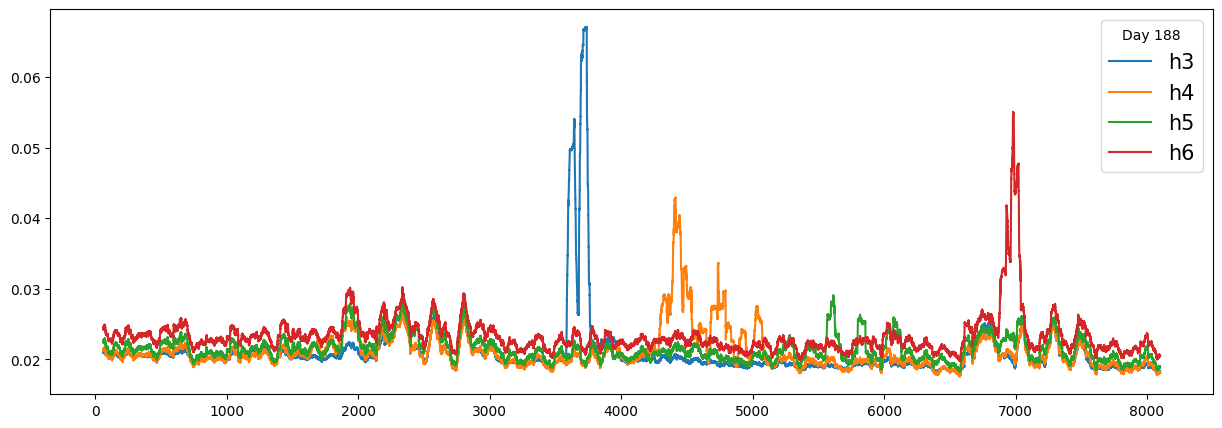

In [19]:
fig, ax = plt.subplots(figsize=(15, 5))

window_size = 1000*60

# day188 = import_data(day=141, starttime='2019-05-21T07:00:00.0Z', endtime='2019-05-21T09:00:00.0Z')
# day141.filter(type='highpass', freq=50)

ax.plot(day197[2].times()[window_size - 1:], moving_average(day197[2].data**2, n=window_size), label='h3')
ax.plot(day197[3].times()[window_size - 1:], moving_average(day197[3].data**2, n=window_size), label='h4')
ax.plot(day197[4].times()[window_size - 1:], moving_average(day197[4].data**2, n=window_size), label='h5')
ax.plot(day197[5].times()[window_size - 1:], moving_average(day197[5].data**2, n=window_size), label='h6')
ax.legend(fontsize=15, title='Day 188')


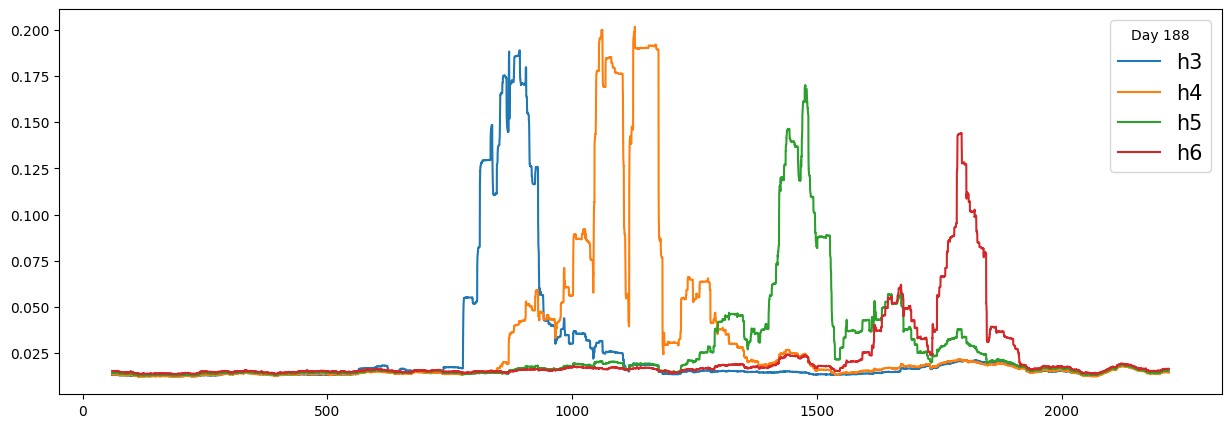

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))

window_size = 1000*60

# day188 = import_data(day=141, starttime='2019-05-21T07:00:00.0Z', endtime='2019-05-21T09:00:00.0Z')
# day141.filter(type='highpass', freq=50)

ax.plot(day211[2].times()[window_size - 1:], moving_average(day211[2].data**2, n=window_size), label='h3')
ax.plot(day211[3].times()[window_size - 1:], moving_average(day211[3].data**2, n=window_size), label='h4')
ax.plot(day211[4].times()[window_size - 1:], moving_average(day211[4].data**2, n=window_size), label='h5')
ax.plot(day211[5].times()[window_size - 1:], moving_average(day211[5].data**2, n=window_size), label='h6')
ax.legend(fontsize=15, title='Day 188')


pvel events before filtering: 54
p-velocity avg: 2460.061136237383
n events for p calculation: 39


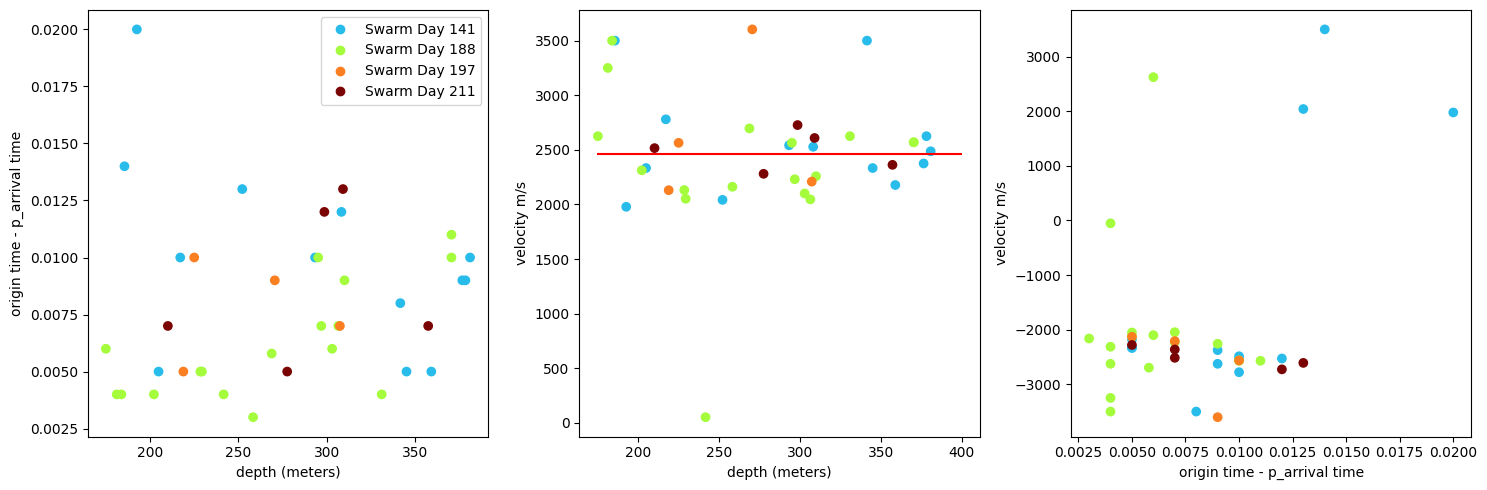

In [21]:
p141 = pd.read_csv('pvels141.csv')
p188 = pd.read_csv('pvels188.csv')
p197 = pd.read_csv('pvels197.csv')
p211 = pd.read_csv('pvels211.csv')

p141['swarm'] = 1
p188['swarm'] = 2
p197['swarm'] = 3
p211['swarm'] = 4

pvels = pd.concat([p141, p188, p197, p211]).reset_index()
print('pvel events before filtering:', pvels.shape[0])

pvels = pvels[(pvels.depths > 150) & (pvels.velocity.abs() < 4000)]

depths = pvels.depths
ptimes = pvels.ptimes
vels = pvels.velocity
swarm_n = pvels.swarm

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

colors = swarm_n/4

ax[0].plot([],[], color=plt.cm.turbo(1/4), linestyle='', marker='o', label='Swarm Day 141')
ax[0].plot([],[], color=plt.cm.turbo(2/4), linestyle='', marker='o', label='Swarm Day 188')
ax[0].plot([],[], color=plt.cm.turbo(3/4), linestyle='', marker='o', label='Swarm Day 197')
ax[0].plot([],[], color=plt.cm.turbo(4/4), linestyle='', marker='o', label='Swarm Day 211')
ax[0].legend()

ax[0].scatter(depths, ptimes, c=plt.cm.turbo(colors))
ax[0].set_xlabel('depth (meters)')
ax[0].set_ylabel('origin time - p_arrival time')

ax[1].scatter(depths, np.abs(vels), c=plt.cm.turbo(colors))
ax[1].hlines(y=np.abs(vels).mean(), xmin=175, xmax=400, color='red')
print('p-velocity avg:', np.abs(vels).mean())
# ax[1].set_xlim(175, 400)
ax[1].set_xlabel('depth (meters)')
ax[1].set_ylabel('velocity m/s')

ax[2].scatter(ptimes, vels, c=plt.cm.turbo(colors))
ax[2].set_xlabel('origin time - p_arrival time')
ax[2].set_ylabel('velocity m/s')

fig.tight_layout()

print('n events for p calculation:', pvels.shape[0])

In [22]:
 def make_tn(df):
    depths = df.depth
    maxamps = df.max_amp
    df = df.copy().arrival_datetime.drop_duplicates()
    tn = df.values
    # time since last event
    ts = []
    # time until next event
    tu = []
    for n, t in enumerate(tn):
        # we use a try/except block to take care of the 
        # failure when looking before the array starts
        # and after the array ends
        try:
            tn_minus1 = tn[n-1]
            tn_plus1 = tn[n+1]
            ts.append(t - tn_minus1)
            tu.append(tn_plus1 - t)
        except:
            pass
    
    tndf = pd.DataFrame(
        {
            'tn-1':ts
            ,'tn':tn[1:]
            ,'tn+1':tu
            ,'depth':depths
            ,'maxamp':maxamps
        }
        ,index=df[1:].index
    )
    tndf['tn-1'] = tndf['tn-1'].apply(lambda t: t.total_seconds())
    tndf['tn+1'] = tndf['tn+1'].apply(lambda t: t.total_seconds())
    return tndf

In [23]:
# remove the first erroneous road
tn141 = make_tn(df=df141)[1:]
tn188 = make_tn(df=df188)[1:]
tn197 = make_tn(df=df197)[1:]
tn211 = make_tn(df=df211)[1:]

tn141['swarm_n'] = 1
tn188['swarm_n'] = 2
tn197['swarm_n'] = 3
tn211['swarm_n'] = 4

tn141['cummaxamp'] = tn141.maxamp.cumsum()
tn188['cummaxamp'] = tn188.maxamp.cumsum()
tn197['cummaxamp'] = tn197.maxamp.cumsum()
tn211['cummaxamp'] = tn211.maxamp.cumsum()

tn141['cumtime'] = tn141['tn-1'].cumsum()
tn188['cumtime'] = tn188['tn-1'].cumsum()
tn197['cumtime'] = tn197['tn-1'].cumsum()
tn211['cumtime'] = tn211['tn-1'].cumsum()

tn141['depthdiff'] = tn141['depth'].diff()
tn188['depthdiff'] = tn188['depth'].diff()
tn197['depthdiff'] = tn197['depth'].diff()
tn211['depthdiff'] = tn211['depth'].diff()

data_for_pred = pd.concat([tn141, tn188, tn197, tn211]).reset_index().fillna(0)

del data_for_pred['index']
data_for_pred.to_csv('mldata.csv', index=False)

In [24]:
df = pd.read_csv('mldata.csv')

df = df[df.depth.between(100, 420)]

df.reset_index(drop=True, inplace=True)

df.sort_values('tn', inplace=True)

df.describe()

,tn-1,tn+1,depth,maxamp,swarm_n,cummaxamp,cumtime,depthdiff
count,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000
mean,3.570652,3.653415,272.044669,4.932295,1.810204,2733.533386,2382.917145,0.262302
std,16.684277,18.344548,63.167642,17.995804,0.872729,2033.532783,1200.067236,33.082055
min,-0.000001,-0.000001,103.500000,0.101230,1.000000,0.259065,8.738000,-280.875000
25%,0.446000,0.446000,219.000000,0.594587,1.000000,1085.649657,1512.761250,-0.875000
50%,0.663000,0.660999,267.125000,1.330682,2.000000,2202.903926,2445.800000,0.000000
75%,1.258000,1.252500,328.156250,3.674996,2.000000,3849.751865,3198.128250,0.875000
max,579.597001,579.597001,414.125000,557.253460,4.000000,8443.321285,6094.117999,392.875000


In [25]:
idx = 1250
df.iloc[idx-24:idx]

# TODO: Make a function that creates new columns based on a lag value
#.      and adds them to the dataframe inplace

def get_autoregressive_vals(df, idx, col, lags):
    # ar_df = df.iloc[idx-lags:idx][col]
    # # print(ar_df.shape)
    # if ar_df.values.shape[0] == 0:
    #     return np.zeros(lags)+np.nan
    # else:
    #     return ar_df.values
    if idx < lags:
        return np.zeros(lags)+np.nan
    else:
        return df.iloc[idx-lags:idx][col]
    
def get_autoregressive_cols(df, lags, col):
    vals = np.zeros([df.shape[0], lags])
    for idx in df.index:
        ar_val = get_autoregressive_vals(df=df, idx=idx, col=col, lags=lags)
        vals[idx] += ar_val
    return pd.DataFrame(vals, columns=[f'{col}_lag_{lag+1}' for lag in range(lags)])

def make_df_with_ar_cols(df, col, lags):
    df = df.copy()
    df.reset_index(drop=True, inplace=True)
    df_ar = get_autoregressive_cols(df=df, lags=lags, col=col)
    return df.join(df_ar)

lags = 80
# df_1 = df[df.swarm_n==1].join(get_autoregressive_cols(df=df[df.swarm_n==1], lags=lags, col='maxamp'))
df_1 = make_df_with_ar_cols(df=df[df.swarm_n==1], lags=lags, col='maxamp')
df_2 = make_df_with_ar_cols(df=df[df.swarm_n==2], lags=lags, col='maxamp')
df_3 = make_df_with_ar_cols(df=df[df.swarm_n==3], lags=lags, col='maxamp')
df_4 = make_df_with_ar_cols(df=df[df.swarm_n==4], lags=lags, col='maxamp')

data_for_catboost = pd.concat([df_1, df_2, df_3, df_4])
# df_2.describe()
# df_1.describe()

In [26]:
data_for_catboost

,tn-1,tn,tn+1,depth,maxamp,swarm_n,cummaxamp,cumtime,depthdiff,maxamp_lag_1,...,maxamp_lag_71,maxamp_lag_72,maxamp_lag_73,maxamp_lag_74,maxamp_lag_75,maxamp_lag_76,maxamp_lag_77,maxamp_lag_78,maxamp_lag_79,maxamp_lag_80
0,10.204,2019-05-21 07:38:57.152000,3.180000,184.000,0.285077,1,0.285077,10.204,0.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.180,2019-05-21 07:38:57.607000,0.455000,170.875,7.151964,1,7.437041,13.384,-13.125,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.455,2019-05-21 07:39:00.080000,2.473000,171.750,43.556691,1,50.993732,13.839,0.875,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.473,2019-05-21 07:39:00.926000,0.846000,170.875,81.321380,1,132.315111,16.312,-0.875,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.846,2019-05-21 07:39:07.065001,6.139001,170.875,2.485894,1,134.801006,17.158,0.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2.662,2019-07-30 23:00:11.177999,10.801000,379.125,36.376443,4,8184.572344,1521.846,140.000,22.177092,...,36.614856,35.496830,64.283263,24.263796,15.360378,170.523931,0.288056,0.383841,0.524237,0.906981
246,10.801,2019-07-30 23:00:27.113999,15.936000,380.000,1.537374,4,8186.109718,1532.647,0.875,68.933981,...,35.496830,64.283263,24.263796,15.360378,170.523931,0.288056,0.383841,0.524237,0.906981,36.376443
247,15.936,2019-07-30 23:00:36.726999,9.613000,387.875,0.245740,4,8186.355457,1548.583,7.875,30.186235,...,64.283263,24.263796,15.360378,170.523931,0.288056,0.383841,0.524237,0.906981,36.376443,1.537374
248,9.613,2019-07-30 23:00:46.209999,9.483000,379.125,24.298655,4,8210.654112,1558.196,-8.750,12.608143,...,24.263796,15.360378,170.523931,0.288056,0.383841,0.524237,0.906981,36.376443,1.537374,0.245740


<Axes: xlabel='tn+1', ylabel='depth'>

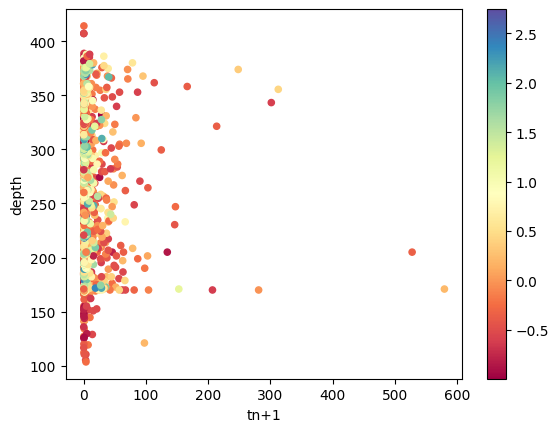

In [27]:
data_for_catboost.plot.scatter(x='tn+1', c=data_for_catboost['maxamp'].apply(np.log10), y='depth', cmap='Spectral')

In [28]:
# data_for_catboost.copy()

# Generate sample data
# x_columns = ['tn-1', 'depth', 'maxamp', 'swarm_n', 'cummaxamp',
x_columns = ['tn-1', 'depth', 'swarm_n', 'cummaxamp',
       'cumtime', 'depthdiff', 
       'maxamp_lag_1', 'maxamp_lag_2', 'maxamp_lag_3', 'maxamp_lag_4',
       'maxamp_lag_5', 'maxamp_lag_6', 'maxamp_lag_7', 'maxamp_lag_8',
       'maxamp_lag_9', 'maxamp_lag_10', 'maxamp_lag_11', 'maxamp_lag_12',
       'maxamp_lag_13', 'maxamp_lag_14', 'maxamp_lag_15', 'maxamp_lag_16',
       'maxamp_lag_17', 'maxamp_lag_18', 'maxamp_lag_19', 'maxamp_lag_20',
       'maxamp_lag_21', 'maxamp_lag_22', 'maxamp_lag_23', 'maxamp_lag_24',
       'maxamp_lag_25', 'maxamp_lag_26', 'maxamp_lag_27', 'maxamp_lag_28',
       'maxamp_lag_29', 'maxamp_lag_30', 'maxamp_lag_31', 'maxamp_lag_32',
       'maxamp_lag_33', 'maxamp_lag_34', 'maxamp_lag_35', 'maxamp_lag_36',
       'maxamp_lag_37', 'maxamp_lag_38', 'maxamp_lag_39', 'maxamp_lag_40',
       'maxamp_lag_41', 'maxamp_lag_42', 'maxamp_lag_43', 'maxamp_lag_44',
       'maxamp_lag_45', 'maxamp_lag_46', 'maxamp_lag_47', 'maxamp_lag_48',
       'maxamp_lag_49', 'maxamp_lag_50', 'maxamp_lag_51', 'maxamp_lag_52',
       'maxamp_lag_53', 'maxamp_lag_54', 'maxamp_lag_55', 'maxamp_lag_56',
       'maxamp_lag_57', 'maxamp_lag_58', 'maxamp_lag_59', 'maxamp_lag_60',
       'maxamp_lag_61', 'maxamp_lag_62', 'maxamp_lag_63', 'maxamp_lag_64',
       'maxamp_lag_65', 'maxamp_lag_66', 'maxamp_lag_67', 'maxamp_lag_68',
       'maxamp_lag_69', 'maxamp_lag_70', 'maxamp_lag_71', 'maxamp_lag_72',
       'maxamp_lag_73', 'maxamp_lag_74', 'maxamp_lag_75', 'maxamp_lag_76',
       'maxamp_lag_77', 'maxamp_lag_78', 'maxamp_lag_79', 'maxamp_lag_80']
# y_column = 'tn+1'
y_column = 'maxamp'
X_train =data_for_catboost[data_for_catboost.swarm_n.isin([1, 2, 3])][x_columns]
y_train =data_for_catboost[data_for_catboost.swarm_n.isin([1, 2, 3])][y_column]
X_test = data_for_catboost[data_for_catboost.swarm_n.isin([4,])][x_columns]
y_test = data_for_catboost[data_for_catboost.swarm_n.isin([4,])][y_column]

# Create CatBoost pools
train_pool = Pool(X_train, y_train,)
test_pool = Pool(X_test, y_test,)

# Define CatBoost parameters
params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'depth': 10,
    # 'loss_function': 'RMSE',
    'verbose': False,
    'objective':'Poisson',
    'has_time':True
}

# Train the CatBoost model
model = cb.CatBoostRegressor(**params)
model.fit(train_pool, eval_set=test_pool, plot=True)

# Make predictions
y_pred_train = model.predict(train_pool)
y_pred_test = model.predict(test_pool)

# Model evaluation
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("Train MSE:", mse_train)
print("Test MSE:", mse_test)
print("Train MAE:", mae_train)
print("Test MAE:", mae_test)
print("Train R^2:", r2_train)
print("Test R^2:", r2_test)

# Plot feature importance
feature_importance = model.get_feature_importance()
# feature_names = ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5']

# plt.barh(feature_names, feature_importance)
# plt.xlabel('Feature Importance')
# plt.ylabel('Features')
feature_importance


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train MSE: 18.252807064100118
Test MSE: 4812.694671991445
Train MAE: 2.07022276193523
Test MAE: 30.702917907224435
Train R^2: 0.6837958471619728
Test R^2: -0.22620717561825399


array([0.81533286, 1.52408748, 3.29482494, 2.31666707, 3.0163493 ,
       0.47120092, 0.40000963, 0.87920436, 1.13625337, 0.        ,
       0.46885957, 0.6634346 , 1.12198858, 1.15201802, 1.10092225,
       3.54707579, 1.50466065, 0.69479662, 0.36594039, 0.57156884,
       0.30510297, 2.43144351, 1.1150418 , 0.12595036, 0.43099397,
       1.30148277, 1.05589531, 1.05826335, 0.5824757 , 0.        ,
       0.79846912, 0.53814885, 1.68149774, 0.80115713, 0.81836912,
       1.19581423, 1.38694552, 0.42387136, 0.18857789, 1.28714776,
       0.25515224, 0.37214035, 1.09471224, 0.8340363 , 0.65827966,
       2.01752039, 1.13864065, 0.14679157, 0.78570592, 1.21037017,
       1.67895765, 0.33800693, 1.20327912, 0.10313669, 1.04714466,
       0.85111782, 0.33369883, 0.84009919, 0.        , 0.76143367,
       0.30937901, 0.95231133, 1.84873295, 2.39126838, 0.21937057,
       0.97308622, 0.38963438, 0.22350657, 1.26522748, 0.56704855,
       2.11224825, 2.59792073, 2.12121444, 0.49253512, 0.86661

In [33]:
numeric_cols = ['tn-1', 'tn+1', 'depth', 'maxamp', 'swarm_n', 'cummaxamp', 'cumtime', 'depthdiff']

[Text(0, 0.5, 'tn-1'),
 Text(0, 1.5, 'tn+1'),
 Text(0, 2.5, 'depth'),
 Text(0, 3.5, 'maxamp'),
 Text(0, 4.5, 'swarm_n'),
 Text(0, 5.5, 'cummaxamp'),
 Text(0, 6.5, 'cumtime'),
 Text(0, 7.5, 'depthdiff')]

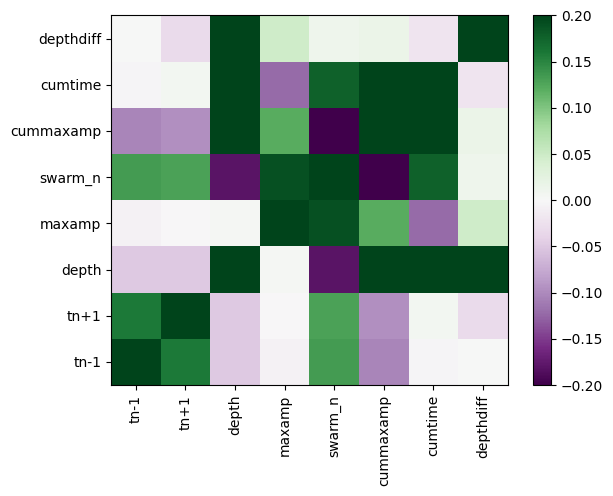

In [52]:
z = df[numeric_cols].corr().values

fig, ax = plt.subplots()

cbar = ax.pcolormesh(z, cmap='PRGn', vmin=-0.2, vmax=0.2)
fig.colorbar(cbar)
ax.set_xticks(np.arange(0.5, 8, 1))
ax.set_yticks(np.arange(0.5, 8, 1))
ax.set_xticklabels(numeric_cols, rotation=90)
ax.set_yticklabels(numeric_cols, rotation=0)

8.487272229158021

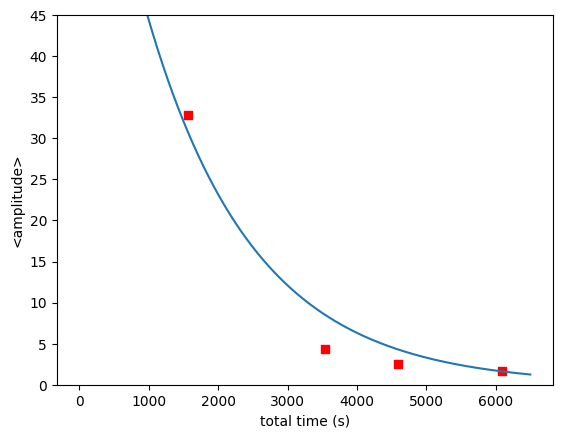

In [35]:
x = df[numeric_cols].groupby('swarm_n').max().cumtime
y = df[numeric_cols].groupby('swarm_n').mean().maxamp
fig, ax = plt.subplots()

ax.scatter(x=x, y=y, linewidth=1, marker='s', color='red')
ax.set_ylabel('<amplitude>')
ax.set_xlabel('total time (s)')


t = np.linspace(0, 6500, 10000)
a = 85 
l = 0.00065
ymod = a * np.exp(-l*t)
ax.plot(t, ymod)

ax.set_ylim(0, 45)

a * np.exp(-l * x.loc[1])